In [84]:
import numpy as np
import trimesh
from tqdm import tqdm
import random 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import linear_sum_assignment


In [85]:
def uniform_sampling_from_mesh(vertices, faces, sample_num):
    # -------- TODO -----------
    # 1. compute area of each triangles
    # 2. compute probability of each triangles from areas
    # 3. sample N faces according to the probability
    # 4. for each face, sample 1 point
    # Note that FOR-LOOP is not allowed!
    # -------- TODO -----------
    # print('vertice:', vertices.shape, 
    #       'faces:', faces.shape, 
    #       'sample_num:', sample_num)
    p = vertices[faces]

    side1 = p[:, 1] - p[:, 0]
    side2 = p[:, 2] - p[:, 0]
    area = np.linalg.norm(np.cross(side1, side2), axis = 1)/2
    
    prob = area/np.sum(area)
    n = faces.shape[0]
    
    idx = random.choices(np.arange(n), weights=prob, k=sample_num)
    p_random = p[idx]

    a = np.random.rand(sample_num, 2)
    idx1 = (a[:, 0] + a[:, 1] <= 1)
    idx2 = (a[:, 0] + a[:, 1] > 1)

    uniform_pc = np.zeros([sample_num, 3])
    weights1 = np.column_stack([a[idx1,0], a[idx1,1], 1-a[idx1,0]-a[idx1,1]])
    uniform_pc[idx1] = (weights1[:,0,None] * p_random[idx1,1] + 
                        weights1[:,1,None] * p_random[idx1,2] +
                        weights1[:,2,None] * p_random[idx1,0])   
    weights2 = np.column_stack([1-a[idx2,0], 1-a[idx2,1], a[idx2,0]+a[idx2,1]])
    weights2 /= weights2.sum(axis=1, keepdims=True)  # 添加归一化
    uniform_pc[idx2] = (weights2[:,0,None] * p_random[idx2,1] + 
                        weights2[:,1,None] * p_random[idx2,2] +
                        weights2[:,2,None] * p_random[idx2,0])    
    return area, prob, uniform_pc
        

In [86]:
def farthest_point_sampling(pc, sample_num):
    # -------- TODO -----------
    # FOR LOOP is allowed here.
    # -------- TODO -----------
    
    # fpc_pc = np.zeros([sample_num, 3])
    # fpc_pc[0] = pc[0]
    print(pc.shape)
    set = np.arange(1, pc.shape[0])
    fpc_set = np.array([0])
    all_dist_matrix = np.linalg.norm(pc[:, np.newaxis, :] - pc, axis = 2)
    # print(dist_matrix.shape)
    
    for i in tqdm(range(1,sample_num)):
        dist_matrix = all_dist_matrix[set][:, fpc_set]#np.linalg.norm(pc[set][:, np.newaxis, :] - fpc_pc[:i], axis = 2)
        dist_min = np.min(dist_matrix, axis = 1)
        idx = np.where(dist_min == np.max(dist_min))
        # fpc_pc[i] = pc[set][idx]

        fpc_set = np.append(fpc_set, set[idx])
        set = np.delete(set, idx)
         
    return pc[fpc_set]

In [87]:
# task 1: uniform sampling 

obj_path = 'spot.obj'
mesh = trimesh.load(obj_path)
print('faces shape: ', mesh.faces.shape)
sample_num = 512
area, prob, uniform_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, sample_num)

# Visualization. For you to check your code
np.savetxt('uniform_sampling_vis.txt', uniform_pc)

print('area shape: ',area.shape)
print('prob shape: ',prob.shape)
print('pc shape: ',uniform_pc.shape)

# the result should satisfy: 
#       area.shape = (13712, ) 
#       prob.shape = (13712, ) 
#       uniform_pc.shape = (512, 3) 

# For submission
save_dict = {'area': area, 'prob': prob, 'pc': uniform_pc}
np.save('../results/uniform_sampling_results', save_dict)

faces shape:  (13712, 3)
area shape:  (13712,)
prob shape:  (13712,)
pc shape:  (512, 3)


In [88]:
def visialize_pc(pc):
    # 生成带高度映射的颜色
    colors = plt.cm.jet(pc[:,2])  # 使用jet色映射根据Z值着色

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制带颜色映射的点云
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], 
                    c=colors, s=20, alpha=0.6, 
                    depthshade=True, marker='o')

    # 设置视角参数
    ax.view_init(elev=90, azim=-90)  # 仰角25度，方位角-45度
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    plt.title('3D Point Cloud with Height Coloring')

    # 添加颜色条
    cbar = plt.colorbar(sc, shrink=0.5)
    cbar.set_label('Height Value')

    plt.tight_layout()
    plt.show()


(2000, 3)


100%|██████████| 511/511 [00:07<00:00, 66.42it/s]


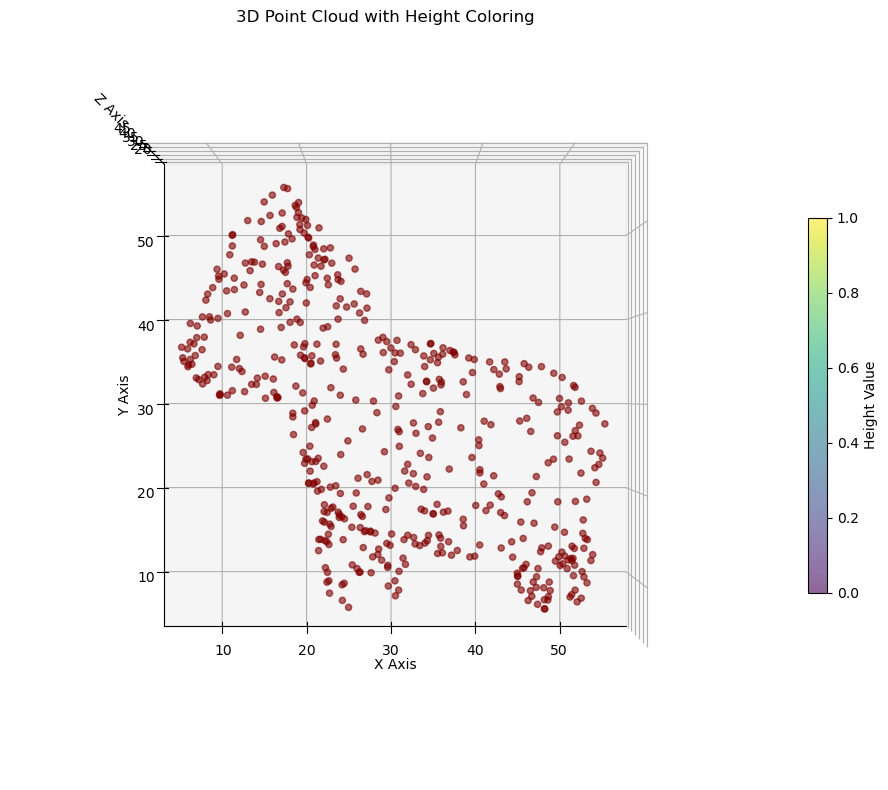

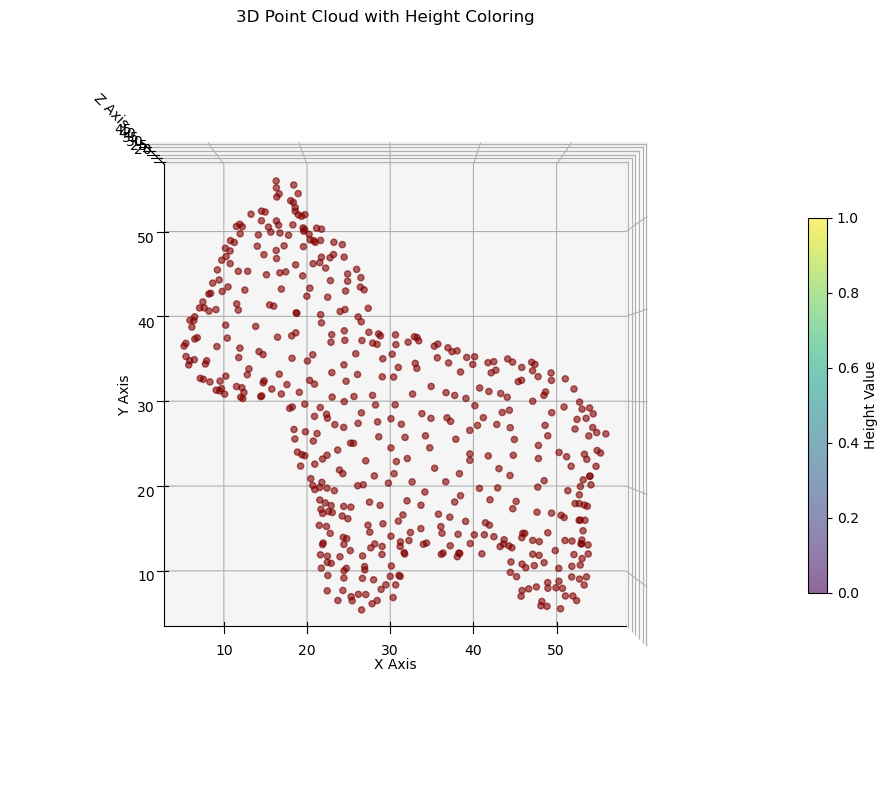

In [89]:
# task 2: FPS

init_sample_num = 2000
final_sample_num = 512
_,_, tmp_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, init_sample_num)
fps_pc = farthest_point_sampling(tmp_pc, final_sample_num)

visialize_pc(uniform_pc)
visialize_pc(fps_pc)

# Visualization. For you to check your code
np.savetxt('fps_vis.txt', fps_pc)

# For submission
np.save('../results/fps_results', fps_pc)

In [90]:
def compute_CD(P, Q):
    dist_matrix = np.linalg.norm(Q[:, np.newaxis, :] - P, axis = 2)
    min_dist = np.min(dist_matrix, axis = 1)
    sum_min_dist = np.sum(min_dist)
    
    dist_matrix = np.linalg.norm(P[:, np.newaxis, :] - Q, axis = 2)
    min_dist = np.min(dist_matrix, axis = 1)
    sum_min_dist += np.sum(min_dist)
    return sum_min_dist

def compute_EMD(P, Q):
    n1, n2 = P.shape[0], Q.shape[0]

    # 计算点间欧氏距离矩阵
    dist_matrix = np.linalg.norm(Q[:, np.newaxis, :] - P, axis = 2)
    
    # 计算EMD（假设均匀分布权重）
    
    assignment = linear_sum_assignment(dist_matrix)[0]
    idx = np.arange(n1)
    emd_value = dist_matrix[idx, assignment]
    
    return np.sum(emd_value)

In [91]:
# task 3: metrics

# from my_earthmover.earthmover import earthmover_distance   # EMD may be very slow (1~2mins)
# -----------TODO---------------
# compute chamfer distance and EMD for two point clouds sampled by uniform sampling and FPS.
# sample and compute CD and EMD again. repeat for five times.
# save the mean and var.
# -----------TODO---------------
chamfer_dist = np.zeros([5])
earthmover_dist = np.zeros([5])

for i in tqdm(range(5)):
    _,_, uniform_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, final_sample_num)
    _,_, tmp_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, init_sample_num)
    fps_pc = farthest_point_sampling(tmp_pc, final_sample_num)
    chamfer_dist[i] = compute_CD(uniform_pc, fps_pc)
    earthmover_dist[i] = compute_EMD(uniform_pc, fps_pc)

CD_mean = np.mean(chamfer_dist)
CD_var = np.var(chamfer_dist)
EMD_mean = np.mean(earthmover_dist)
EMD_var = np.var(earthmover_dist)
# print(CD_mean, CD_var, EMD_mean, EMD_var)
# For submission
np.save('../results/metrics', {'CD_mean':CD_mean, 'CD_var':CD_var, 'EMD_mean':EMD_mean, 'EMD_var':EMD_var})

  0%|          | 0/5 [00:00<?, ?it/s]

(2000, 3)


 20%|██        | 1/5 [00:08<00:32,  8.07s/it]

(2000, 3)


 40%|████      | 2/5 [00:16<00:24,  8.17s/it]

(2000, 3)


 60%|██████    | 3/5 [00:24<00:16,  8.01s/it]

(2000, 3)


 80%|████████  | 4/5 [00:32<00:08,  8.09s/it]

(2000, 3)


100%|██████████| 5/5 [00:40<00:00,  8.12s/it]
